## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [ ]:
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus

In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = '0b3ee52629194bf5a305995f09a5fab7.10b8HNjwBqf6KtiH5wWWZ8Pg'

## 📦 Setup and Configuration
Import required packages and setup environment.

In [1]:
import os
import json
import requests
import pyinputplus as pyip
import matplotlib.pyplot as plt

# OpenWeather key: prefer env var; prompt once if absent
OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
if not OPENWEATHER_API_KEY:
    OPENWEATHER_API_KEY = pyip.inputStr("Enter your OpenWeather API key:\n")
    os.environ["OPENWEATHER_API_KEY"] = OPENWEATHER_API_KEY


Enter your OpenWeather API key:
707319d8eaa81955d0542f21f32593ae


## 🌤️ Weather Data Functions

In [2]:
def get_weather_data(location, forecast_days=5):
    """
    Returns dict with keys: 'current' (weather JSON) and 'forecast' (5-day/3h JSON).
    """
    api_key = os.getenv("OPENWEATHER_API_KEY")
    if not api_key:
        print("Missing OPENWEATHER_API_KEY.")
        return None

    forecast_days = max(1, min(5, int(forecast_days or 1)))  # clamp to 1..5
    base = "http://api.openweathermap.org/data/2.5/"
    try:
        # Step 1: get lat/lon via current weather lookup
        geocode_url = f"{base}weather?q={location}&appid={api_key}&units=metric"
        r = requests.get(geocode_url, timeout=15)
        r.raise_for_status()
        geo = r.json()
        cod = str(geo.get("cod", "200"))
        if cod != "200":
            print(f"Error: {geo.get('message','unknown error')}")
            return None
        lat = geo["coord"]["lat"]
        lon = geo["coord"]["lon"]

        # Step 2: get 5-day/3h forecast; we'll just keep the first N*8 slots (~8 slots ~ 1 day)
        fc_url = f"{base}forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"
        fr = requests.get(fc_url, timeout=15)
        fr.raise_for_status()
        forecast = fr.json()

        # Trim list to requested days
        slots = forecast_days * 8
        if isinstance(forecast.get("list"), list):
            forecast["list"] = forecast["list"][:slots]

        return {"current": geo, "forecast": forecast}
    except requests.HTTPError as e:
        print(f"HTTP error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    return None

## 📊 Visualisation Functions

In [3]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a temperature visualization from weather forecast data.

    Color code:
    - Red: temperature > 25°C
    - Blue: temperature < 15°C
    - Green: 15°C ≤ temperature ≤ 25°C
    """
    if not weather_data or 'forecast' not in weather_data:
        print("No weather data available for temperature visualization.")
        return None

    forecast_list = weather_data['forecast']['list']
    dates = [item['dt_txt'] for item in forecast_list]
    temperatures = [item['main']['temp'] for item in forecast_list]

    # Assign colors based on temperature thresholds
    colors = [
        'red' if temp > 25 else
        'blue' if temp < 15 else
        'green'
        for temp in temperatures
    ]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Draw colored segments between points for better continuity
    for i in range(1, len(dates)):
        ax.plot(
            dates[i-1:i+1],
            temperatures[i-1:i+1],
            color=colors[i],
            linewidth=2
        )

    # Plot points on top for clarity
    ax.scatter(dates, temperatures, c=colors, s=50, edgecolor='black')

    ax.set_title('Temperature Forecast')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Temperature (°C)')
    ax.tick_params(axis='x', rotation=45)
    plt.grid(True)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()


In [10]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Creates a precipitation bar chart.
    Shows 'NO RAIN' vertically above days with zero precipitation.
    """
    if not weather_data or 'forecast' not in weather_data:
        print("No weather data available for precipitation visualization.")
        return None

    forecast_list = weather_data['forecast']['list']
    dates = [item['dt_txt'] for item in forecast_list]

    # Combine rain + snow per forecast entry (3-hour intervals)
    precipitation = [
        item.get('rain', {}).get('3h', 0) + item.get('snow', {}).get('3h', 0)
        for item in forecast_list
    ]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(
        dates,
        precipitation,
        color=['skyblue' if p > 0 else 'lightgray' for p in precipitation]
    )

    # Add vertical “NO RAIN” labels for zero-precipitation bars
    for i, (bar, value) in enumerate(zip(bars, precipitation)):
        if value == 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.05,
                "NO\nRAIN",  # newline makes it stack vertically
                ha='center',
                va='bottom',
                fontsize=8,
                color='gray',
                fontweight='bold',
                rotation=90  # ensures vertical orientation
            )

    ax.set_title('Precipitation Forecast (mm in last 3 hours)')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Precipitation (mm)')
    ax.tick_params(axis='x', rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

## 🤖 Natural Language Processing

In [6]:
from hands_on_ai.chat import get_response

def parse_weather_question(question):
    try:
        # Assuming get_response can take a system message and user message
        response = get_response(prompt)
        # Attempt to parse the response as JSON
        import json
        parsed_data = json.loads(response)
        return parsed_data
    except Exception as e:
        print(f"Error parsing weather question: {e}")
        return None

## 🧭 User Interface

In [7]:
def main_menu():
    print("Welcome to WeatherWise!")
    choices = ['Get Weather Forecast', 'Ask a Weather Question', 'View Visualisations', 'Exit']
    response = pyip.inputMenu(choices, prompt='Please select an option:\n', numbered=True)
    return response

def get_location_input():
    location = pyip.inputStr(prompt='Enter the city or location:\n')
    return location

def get_forecast_days_input():
    days = pyip.inputInt(prompt='Enter the number of forecast days (1-5):\n', min=1, max=5)
    return days

def get_weather_question_input():
    question = pyip.inputStr(prompt='Enter your weather question:\n')
    return question

## 🧩 Main Application Logic

In [8]:
def generate_weather_response(parsed_question, weather_data):
    if not parsed_question or not weather_data:
        return "I could not understand your question or retrieve weather data."

    location = parsed_question.get("location")
    time_period = parsed_question.get("time_period")
    weather_attribute = parsed_question.get("weather_attribute")

    try:
        response = get_response(prompt)
        return response
    except Exception as e:
        print(f"Error generating weather response: {e}")
        return "Sorry, I could not generate a response at this time."

## 🧪 Testing and Examples

Welcome to WeatherWise!
Please select an option:
1. Get Weather Forecast
2. Ask a Weather Question
3. View Visualisations
4. Exit
3
Enter the city or location:
Hyderabad
Enter the number of forecast days (1-5):
5

Generating Visualisations...


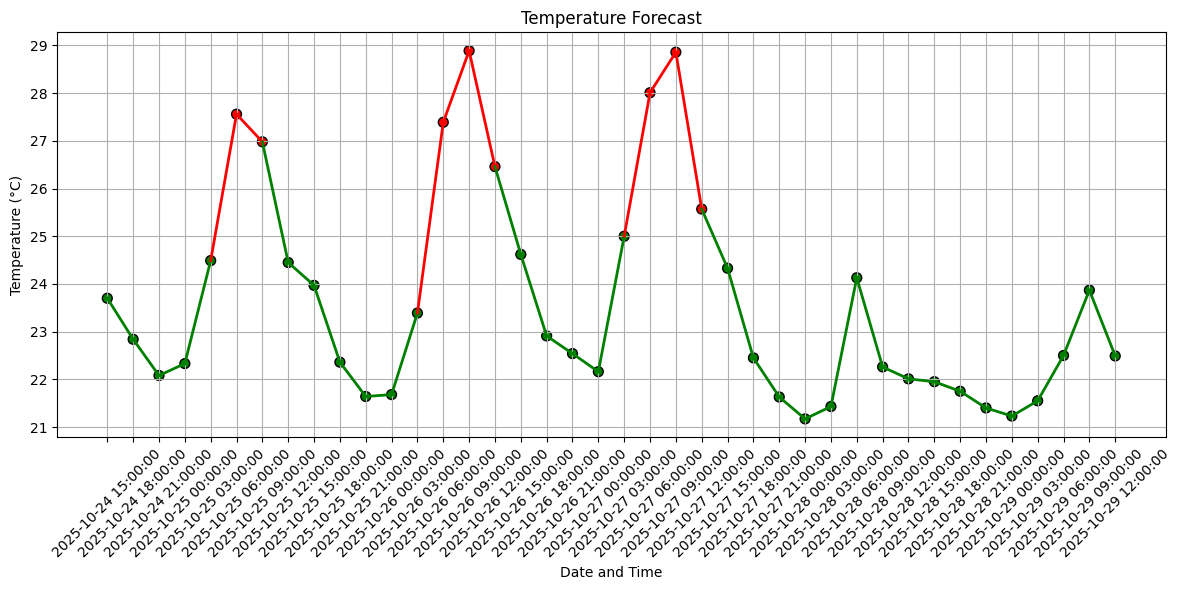

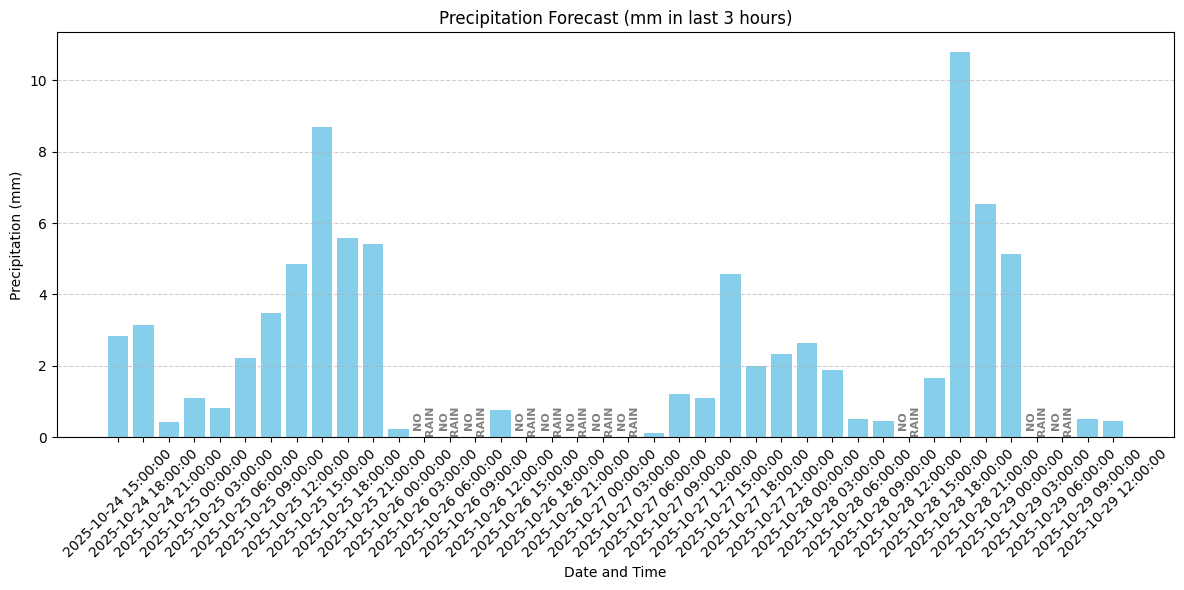

Welcome to WeatherWise!
Please select an option:
1. Get Weather Forecast
2. Ask a Weather Question
3. View Visualisations
4. Exit
4
Thank you for using WeatherWise!


In [11]:
def run_weather_advisor():
    """
    Runs the main weather advisor application loop.
    """
    while True:
        choice = main_menu()

        if choice == 'Get Weather Forecast':
            location = get_location_input()
            days = get_forecast_days_input()
            weather_data = get_weather_data(location, days)
            if weather_data:
                print("\nWeather Forecast:")
                # You can format and print the forecast data here
                # For now, let's just print the raw data
                import json
                print(json.dumps(weather_data, indent=4))

        elif choice == 'Ask a Weather Question':
            question = get_weather_question_input()
            # We need a location for the weather data, maybe ask for it here
            location = get_location_input() # Assuming location is needed for the question as well
            weather_data = get_weather_data(location) # Fetch weather data for the location
            parsed_question = parse_weather_question(question)
            response = generate_weather_response(parsed_question, weather_data)
            print(f"\nWeather Advisor says: {response}")

        elif choice == 'View Visualisations':
            location = get_location_input()
            days = get_forecast_days_input() # Get days for forecast data needed for visualization
            weather_data = get_weather_data(location, days)
            if weather_data:
                print("\nGenerating Visualisations...")
                create_temperature_visualisation(weather_data)
                create_precipitation_visualisation(weather_data)

        elif choice == 'Exit':
            print("Thank you for using WeatherWise!")
            break

if __name__ == "__main__":
    run_weather_advisor()

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.